In [1]:
import scanpy as sc
import surgeon

Using TensorFlow backend.


In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas Celseq", "Pancreas CelSeq2"]

# Loading four Toy datasets and data preparation

In [4]:
adata = sc.read("./data/pancreas/pancreas_count.h5ad")
adata

AnnData object with n_obs × n_vars = 15921 × 15369 
    obs: 'batch', 'study', 'cell_type'

## Number of cells in each batch

In [5]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8569
Pancreas SS2            2989
Pancreas CelSeq2        2449
Pancreas Celseq         1276
Pancreas Fluidigm C1     638
Name: study, dtype: int64

## Now we leave out one study (SS2) for training the newtork

In [6]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 12196 × 15369 
    obs: 'batch', 'study', 'cell_type'

In [7]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 3725 × 15369 
    obs: 'batch', 'study', 'cell_type'

In [8]:
adata_for_training = surgeon.utils.normalize(adata_for_training, 
                                             filter_min_counts=False, 
                                             normalize_input=False, 
                                             size_factors=True,
                                             logtrans_input=True,
                                             n_top_genes=2000,
                                            )

Trying to set attribute `.obs` of view, making a copy.


In [9]:
adata_out_of_sample = surgeon.utils.normalize(adata_out_of_sample, 
                                              filter_min_counts=False, 
                                              normalize_input=False, 
                                              size_factors=True,
                                              logtrans_input=True,
                                              n_top_genes=2000,
                                             )

Trying to set attribute `.obs` of view, making a copy.


## Train/Test Split

In [10]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [11]:
train_adata.shape, valid_adata.shape

((10366, 2000), (1830, 2000))

In [12]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [13]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[128],
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             scale_factor=1.0,
                             clip_value=3.0,
                             loss_fn='nb',
                             model_path="./models/CVAE/pancreas_unfreezed/before/",
                             dropout_rate=0.2,
                             )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2003)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

/home/mohsen/scnet/surgeon/models/_cvae.py:154: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


## We assign each study to a numerical label 

In [14]:
conditions = adata_for_training.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Pancreas inDrop': 0, 'Pancreas Fluidigm C1': 1, 'Pancreas SS2': 2}

## Training the network

In [15]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=1000,
              batch_size=32, 
              early_stop_limit=50,
              lr_reducer=40, 
              n_per_epoch=0,
              save=True, 
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 10366 samples, validate on 1830 samples
Epoch 1/1000
 - 2s - loss: 0.7466 - nb: 0.7466 - val_loss: 0.6823 - val_nb: 0.6823
Epoch 2/1000
 - 1s - loss: 0.6730 - nb: 0.6730 - val_loss: 0.6695 - val_nb: 0.6695
Epoch 3/1000
 - 2s - loss: 0.6632 - nb: 0.6632 - val_loss: 0.6621 - val_nb: 0.6621
Epoch 4/1000
 - 2s - loss: 0.6574 - nb: 0.6574 - val_loss: 0.6588 - val_nb: 0.6588
Epoch 5/1000
 - 2s - loss: 0.6539 - nb: 0.6539 - val_loss: 0.6567 - val_nb: 0.6567
Epoch 6/1000
 - 3s - loss: 0.6516 - nb: 0.6516 - val_loss: 0.6546 - val_nb: 0.6546
Epoch 7/1000
 - 3s - loss: 0.6497 - nb: 0.6497 - val_loss: 0.6526 - val_nb: 0.6526
Epoch 8/1000
 - 3s - loss: 0.6482 - nb: 0.6482 - val_loss: 0.6517 - val_nb: 0.6517
Epoch 9/1000
 - 3s - loss: 0.6471 - nb: 0.6471 - val_loss: 0.6509 - val_nb: 0.6509
Epoch 10/1000
 - 3s - loss: 0.6462 - nb: 0.6462 - val_loss: 0.6503 - val_nb: 0.6503
Epoch 11/1000
 - 3s - loss: 0.6455 - nb: 0.6455 - val_loss: 0.6497 - val

In [16]:
network.condition_encoder

{'Pancreas inDrop': 0, 'Pancreas Fluidigm C1': 1, 'Pancreas SS2': 2}

In [17]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [18]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 10366 × 10 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [19]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

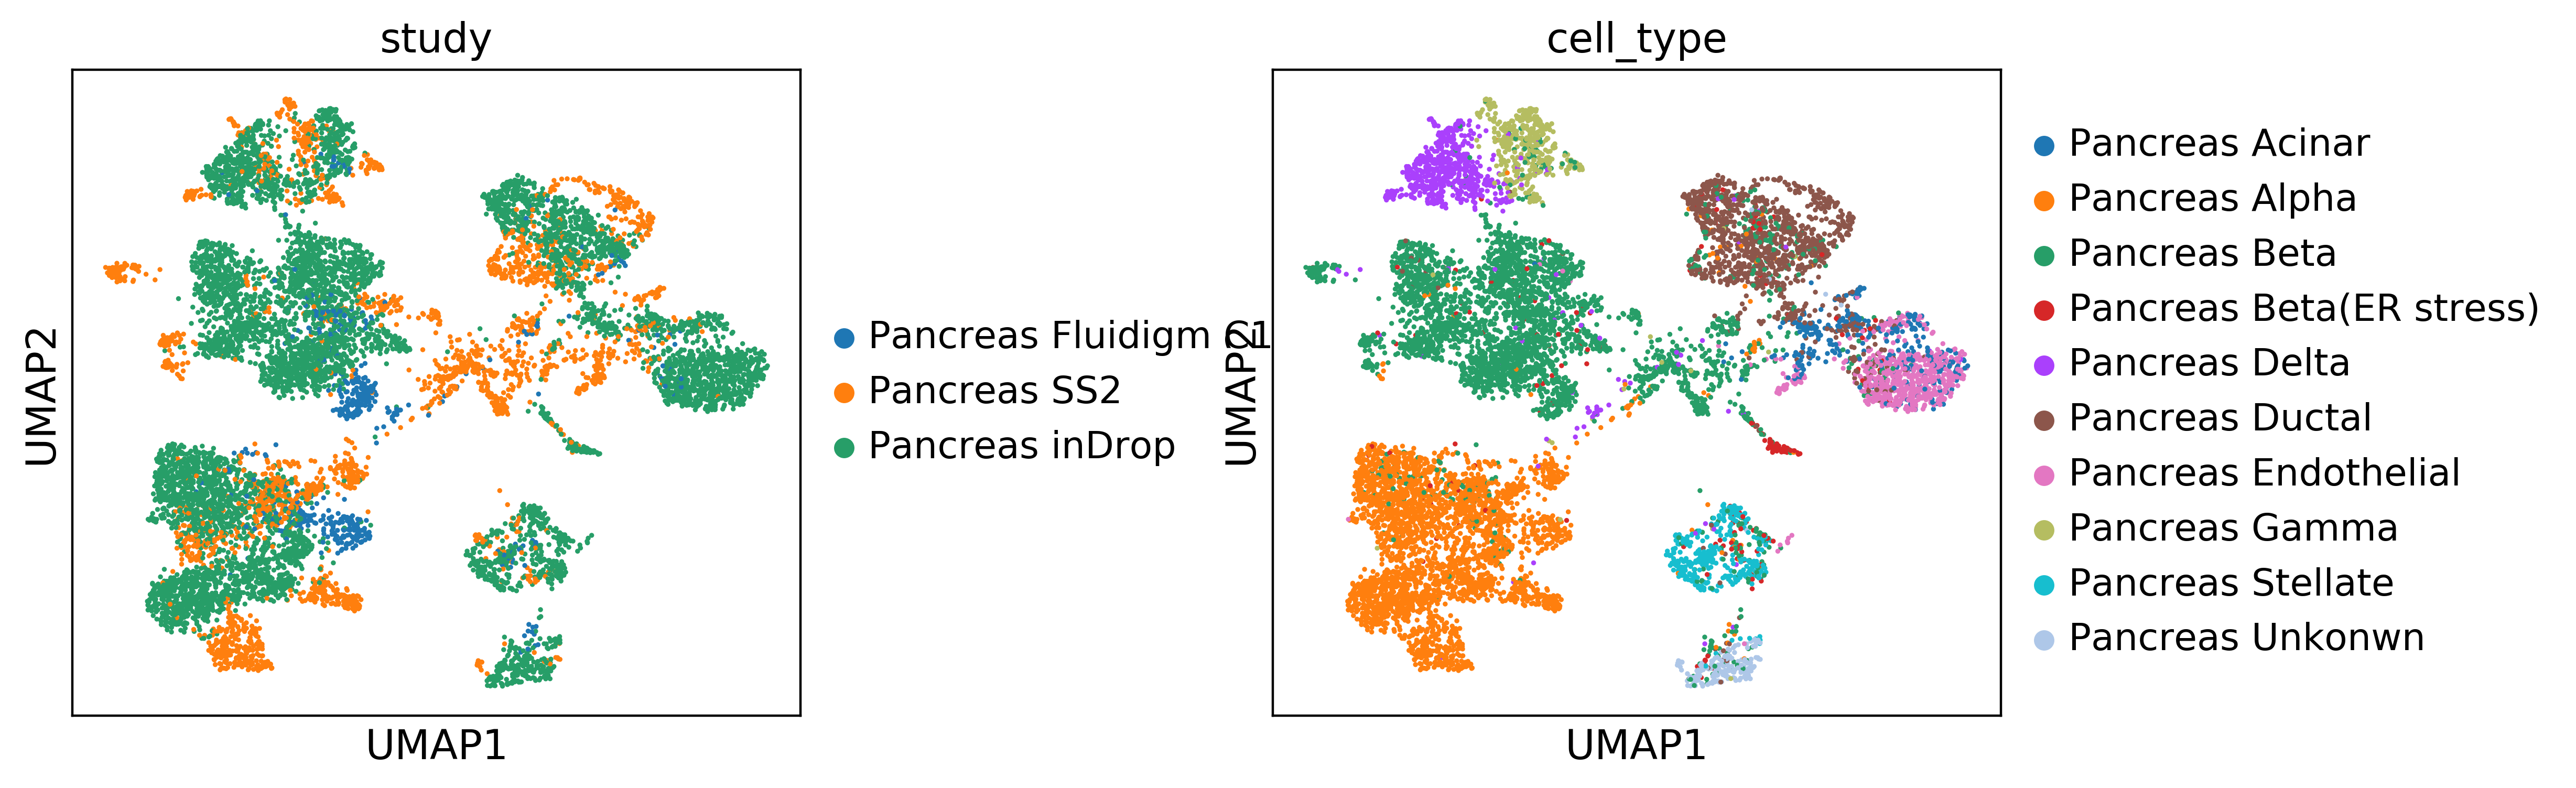

In [20]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [21]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              remove_dropout=True,
                              init='Xavier', 
                              freeze=False)

/home/mohsen/scnet/surgeon/models/_cvae.py:154: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2005)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 128)          256640      concatenate_3[0][0]              
__________

In [22]:
new_network.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas Fluidigm C1': 1,
 'Pancreas SS2': 2,
 'Pancreas Celseq': 3,
 'Pancreas CelSeq2': 4}

In [27]:
new_network.model_path = "./models/CVAE/pancreas_unfreezed/after/"

## Train with small new dataset containing out-of-sample condition

In [28]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.80)

In [29]:
train_adata.shape, valid_adata.shape

((2980, 2000), (745, 2000))

In [30]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=400,
                  n_epochs_warmup=200,
                  batch_size=32, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  n_per_epoch=0,
                  save=True, 
                  verbose=2)

Train on 2980 samples, validate on 745 samples
Epoch 1/200
 - 0s - loss: 0.8518 - nb: 0.8518 - val_loss: 0.7745 - val_nb: 0.7745
Epoch 2/200
 - 0s - loss: 0.7801 - nb: 0.7801 - val_loss: 0.7580 - val_nb: 0.7580
Epoch 3/200
 - 0s - loss: 0.7681 - nb: 0.7681 - val_loss: 0.7508 - val_nb: 0.7508
Epoch 4/200
 - 0s - loss: 0.7616 - nb: 0.7616 - val_loss: 0.7455 - val_nb: 0.7455
Epoch 5/200
 - 0s - loss: 0.7569 - nb: 0.7569 - val_loss: 0.7421 - val_nb: 0.7421
Epoch 6/200
 - 0s - loss: 0.7537 - nb: 0.7537 - val_loss: 0.7398 - val_nb: 0.7398
Epoch 7/200
 - 0s - loss: 0.7511 - nb: 0.7511 - val_loss: 0.7376 - val_nb: 0.7376
Epoch 8/200
 - 0s - loss: 0.7491 - nb: 0.7491 - val_loss: 0.7359 - val_nb: 0.7359
Epoch 9/200
 - 0s - loss: 0.7475 - nb: 0.7475 - val_loss: 0.7347 - val_nb: 0.7347
Epoch 10/200
 - 0s - loss: 0.7462 - nb: 0.7462 - val_loss: 0.7334 - val_nb: 0.7334
Epoch 11/200
 - 0s - loss: 0.7449 - nb: 0.7449 - val_loss: 0.7325 - val_nb: 0.7325
Epoch 12/200
 - 0s - loss: 0.7439 - nb: 0.7439 - 

In [34]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [35]:
adata_out_of_sample.obs[condition_key].value_counts()

Pancreas CelSeq2    2449
Pancreas Celseq     1276
Name: study, dtype: int64

In [36]:
latent_adata = new_network.to_latent(adata_out_of_sample, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 3725 × 10 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [37]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


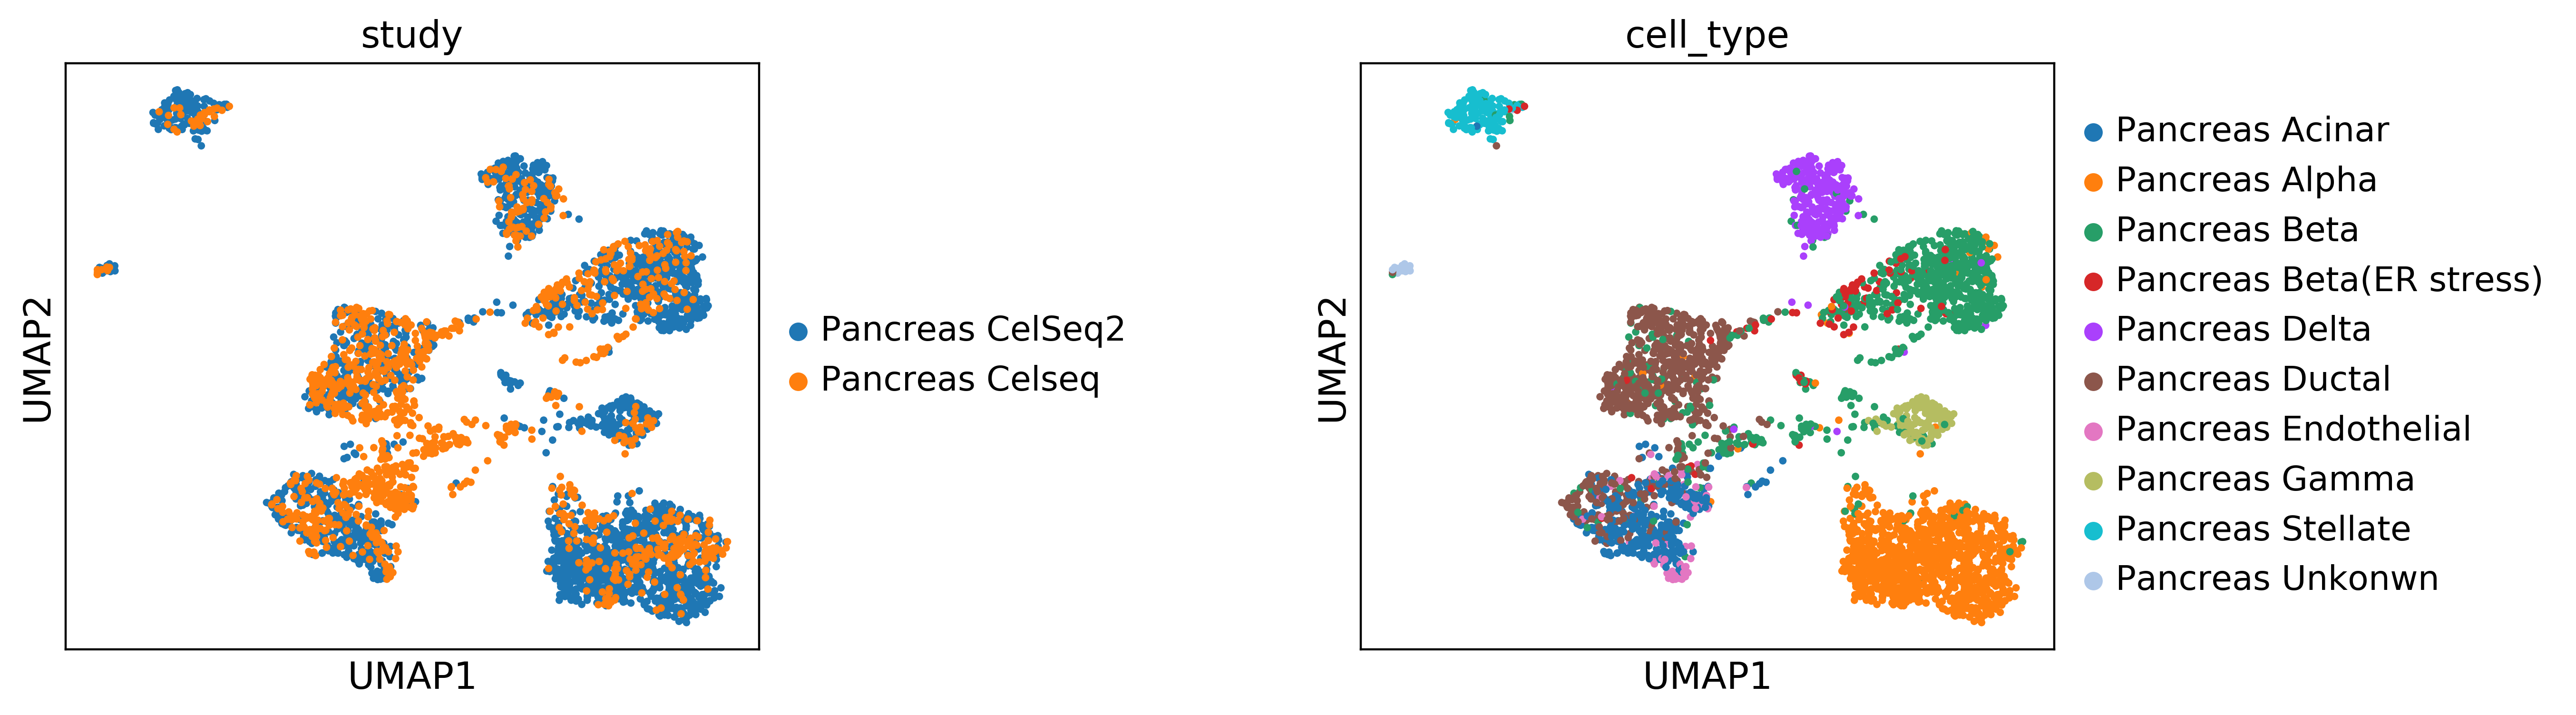

In [38]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.7)

In [39]:
surgeon.metrics.ari(latent_adata, cell_type_key)

0.7145034764072451

In [40]:
surgeon.metrics.nmi(latent_adata, cell_type_key)

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.7127340735632417